In [1]:
import os
import lightgbm as lgb
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import winsound
import datetime

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/datasets")
os.chdir("C:/diego_tools/labo3/dataset")
####################################################

In [3]:
arch_sellout_train = "emp3_sellout_product_train.csv"
arch_min_max_prod = "emp3_min_max_prod.csv"
arch_mean_std_prod = "emp3_mean_std_prod.csv"
arch_prod_ids_prediccion = "productos_a_predecir.csv"
arch_predicciones_full = "emp3_lightgbm_prediccion_full.csv"
arch_predicciones_simple = "emp3_lightgbm_prediccion.csv"

In [4]:
tipos_transf = ['sin_transformacion', 'normalizacion', 'estandarizacion']
GLOBAL_TRANSF = tipos_transf[0]
iteraciones_random_search = 50


GLOBAL_PRODUCT_IDS = pd.DataFrame() #aca solamente se define, se setea mas abajo

In [5]:
# Marco en train, holdout y descartar para considerarlo en las transformaciones
periodo_inicio=201701 #inclusive
train_periodo_limite = 201810 #inclusive
validate_periodo = 201812
train_all_periodo_limite = 201812 #inclusive
holdout_periodo = 201902

In [6]:
########### NORMALIZACION
def normalizar_valor(valor,minimo,maximo):
    if np.isnan(minimo):
        return valor #si no hay minimo, devuelvo valor original (no tener minimo significa que no habia datos en train)
    else:
        if (maximo-minimo)==0: 
            return 0
        else:
            return (valor - minimo) / (maximo-minimo)

        
def desnormalizar_valor(valor,minimo,maximo):
    if np.isnan(minimo):
        return valor #si no hay minimo, devuelvo valor original (no tener minimo significa que no habia datos en train)
    else:
        return (valor * (maximo-minimo)) + minimo

def normalizar_tn(df_param):
    #Calculo min max solamente sobre train (para evitar data leakage)
    df_train = df_param[(df_param.periodo<=train_periodo_limite) & (df_param.periodo >= periodo_inicio)]
    df_train = df_train[["product_id","tn"]]
    
    #Calculo min max por producto y lo guardo para poder revertir posteriormente
    df_min_max_prod = df_train.groupby('product_id')['tn'].agg(['max', 'min']).reset_index()
    df_min_max_prod = df_min_max_prod.rename(columns={"min":"valor_1","max":"valor_2"})
    df_min_max_prod.to_csv(arch_min_max_prod, index=False)
        
    df_ret = df_param.merge(df_min_max_prod,how="left",on="product_id") #puede haber productos que no aparezcan, por eso left
    
    # Selecciono columnas a normalizar
    
    # Me guardo la original para comparar
    df_ret["tn_original"]=df_ret.tn
    
    # Dropeo algunas (para evitar ruido)
    cols_remover = ["cust_request_tn","dif_cust_request_tn","cust_request_qty"]
    cols_remover.extend([col for col in df_ret.columns if "cat1_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat2_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat3_" in col])
        
    df_ret = df_ret.drop(columns=cols_remover)  
    
    # Normalizo tn, lags y deltas
    lag_cols = [col for col in df_ret.columns if "lag" in col]
    delta_cols = [col for col in df_ret.columns if "delta" in col]
    cols_norm = ["tn","tn_mas_2"]
    cols_norm.extend(lag_cols)
    cols_norm.extend(delta_cols)
                    
    for col_norm in cols_norm:
        df_ret[col_norm] =df_ret.apply(lambda row: normalizar_valor(row[col_norm],row["valor_1"],row["valor_2"]),axis=1)
    
    return df_ret

############# ESTANDARIZACION
def estandarizar_valor(valor,media,desvio):
    if np.isnan(media):
        return valor #si no hay media, devuelvo valor original (no tener media significa que no habia datos en train)
    else:
        if desvio==0: 
            return 0
        else:
            return (valor - media) / desvio

def desestandarizar_valor(valor,media,desvio):
    if np.isnan(media):
        return valor #si no hay media, devuelvo valor original (no tener media significa que no habia datos en train)
    else:
        return (valor * desvio) + media
    
def estandarizar_tn(df_param):
    #Calculo min max solamente sobre train (para evitar data leakage)
    df_train = df_param[(df_param.periodo<=train_periodo_limite) & (df_param.periodo >= periodo_inicio)]
    df_train = df_train[["product_id","tn"]]
    
    #Calculo media y desvio por producto y lo guardo para poder revertir posteriormente
    df_mean_std_prod = df_train.groupby('product_id')['tn'].agg(['mean', lambda x: np.std(x,ddof=0)]).reset_index() #se usa ddof=0 para evitar NaN cuando hay un solo producto
    df_mean_std_prod.columns = ["product_id",'valor_1', 'valor_2']
    df_mean_std_prod.to_csv(arch_mean_std_prod, index=False)
        
    df_ret = df_param.merge(df_mean_std_prod,how="left",on="product_id")
    
    # Selecciono columnas a estandarizar
    
    # Me guardo la original para comparar
    df_ret["tn_original"]=df_ret.tn
    
    # Dropeo algunas (para evitar ruido)
    cols_remover = ["cust_request_tn","dif_cust_request_tn","cust_request_qty"]
    cols_remover.extend([col for col in df_ret.columns if "cat1_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat2_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat3_" in col])
        
    df_ret = df_ret.drop(columns=cols_remover)  
    
    # Estandarizo tn, lags y deltas
    lag_cols = [col for col in df_ret.columns if "lag" in col]
    delta_cols = [col for col in df_ret.columns if "delta" in col]
    cols_norm = ["tn","tn_mas_2"]
    cols_norm.extend(lag_cols)
    cols_norm.extend(delta_cols)
                    
    for col_norm in cols_norm:
        df_ret[col_norm] =df_ret.apply(lambda row: estandarizar_valor(row[col_norm],row["valor_1"],row["valor_2"]),axis=1)
    
    return df_ret

################### TRANSFORMACION    
def transformar_valor(valor,var1,var2):
    if GLOBAL_TRANSF=="normalizacion":
        return normalizar_valor(valor,var1,var2)
    elif GLOBAL_TRANSF=="estandarizacion":
        return estandarizar_valor(valor,var1,var2)
    else:
        return valor

def destransformar_valor(valor,var1,var2):
    if GLOBAL_TRANSF=="normalizacion":
        return desnormalizar_valor(valor,var1,var2)
    elif GLOBAL_TRANSF=="estandarizacion":
        return desestandarizar_valor(valor,var1,var2)
    else:
        return valor

def graficar_ejemplo_transformacion(df_param):
    df_param = df_param[df_param.product_id==20001]
    
    plt.plot(df_param.tn_original)
    plt.title("Original")
    plt.show()
    
    plt.plot(df_param.tn)
    plt.title("Transformado")
    plt.show()

In [7]:
############ DEFINO Vector Global de Productos #################
def actualizar_global_prods(y_vector):
    # Ademas del id y los valores para "destransformar", se deja el tn original porque la destransformacion puede no ser
    # precisa para productos que no estaban en train
    GLOBAL_PRODUCT_IDS = pd.DataFrame(data={"product_id":X_holdout.product_id, "tn_orig":np.array(y_vector)})
    GLOBAL_PRODUCT_IDS = GLOBAL_PRODUCT_IDS.merge(df_prod_val1_val2,how="left",on="product_id")
    GLOBAL_PRODUCT_IDS = GLOBAL_PRODUCT_IDS.sort_values(by="product_id",ascending=True)
    
    return GLOBAL_PRODUCT_IDS

In [8]:
def error_rate(y, y_pred):
    y_pred = np.array(y_pred)
    
    #Solamente destransformo la prediccion (para el y tomo el original de la columna tn_orig)
    df_calculo = GLOBAL_PRODUCT_IDS.copy()
    df_calculo["y_pred"] = y_pred
    df_calculo["y_pred_destransformado"]=df_calculo.apply(lambda row: destransformar_valor(row["y_pred"],row["valor_1"],row["valor_2"]),axis=1)

    y = df_calculo.tn_orig
    y_pred = df_calculo.y_pred_destransformado
    
    #Las predicciones negativas se convierten a 0
    y_pred = np.maximum(y_pred, 0)
    
    dif_abs = sum(abs(y - y_pred))
    suma_real = sum(y)
    return round(100*dif_abs/suma_real,2)

def lgbm_error_rate(preds, train_data):
    labels = train_data.get_label()
    ret_val = error_rate(labels,preds)
    return 'ER', ret_val, False

In [9]:
def destransformar_vector(y_vector):
    df_calculo = GLOBAL_PRODUCT_IDS.copy()
    df_calculo["y"] = y_vector
    df_calculo["y_destransformado"]=df_calculo.apply(lambda row: destransformar_valor(row["y"],row["valor_1"],row["valor_2"]),axis=1)

    return df_calculo.y_destransformado

In [10]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

In [11]:
##############################################

In [12]:
df_sellout = pd.read_csv(arch_sellout_train)

In [13]:
df_sellout.head()

,product_id,periodo,imputado,tn,cust_request_tn,cust_request_qty,plan_precios_cuidados,periodo_fecha,mes,meses_historia,cat1,cat2,cat3,brand,sku_size,producto_estrella,temp_media,temp_max_media,temp_min_media,IPC,promedio_mens_dolar_venta,catastrofe,dif_cust_request_tn,dif_cust_request_tn_porc,tn_lag_1,tn_lag_2,tn_lag_3,tn_lag_4,tn_lag_5,tn_lag_6,tn_lag_7,tn_lag_8,tn_lag_9,tn_lag_10,tn_lag_11,tn_lag_12,tn_lag_13,tn_lag_14,tn_lag_15,tn_mas_2,tn_delta_1,tn_delta_2,tn_delta_3,tn_delta_4,tn_delta_5,tn_delta_6,tn_delta_7,tn_delta_8,tn_delta_9,tn_delta_10,tn_delta_11,tn_delta_12,tn_delta_13,tn_delta_14,tn_delta_15,cat1_tn,cat1_tn_lag_1,cat1_tn_delta_1,cat1_tn_lag_2,cat1_tn_delta_2,cat1_tn_lag_3,cat1_tn_delta_3,cat1_tn_lag_4,cat1_tn_delta_4,cat1_tn_lag_5,cat1_tn_delta_5,cat1_tn_lag_6,cat1_tn_delta_6,cat1_tn_lag_7,cat1_tn_delta_7,cat1_tn_lag_8,cat1_tn_delta_8,cat1_tn_lag_9,cat1_tn_delta_9,cat1_tn_lag_10,cat1_tn_delta_10,cat1_tn_lag_11,cat1_tn_delta_11,cat1_tn_lag_12,cat1_tn_delta_12,cat1_tn_lag_13,cat1_tn_delta_13,cat1_tn_lag_14,cat1_tn_delta_14,cat1_tn_lag_15,cat1_tn_delta_15,cat2_tn,cat2_tn_lag_1,cat2_tn_delta_1,cat2_tn_lag_2,cat2_tn_delta_2,cat2_tn_lag_3,cat2_tn_delta_3,cat2_tn_lag_4,cat2_tn_delta_4,cat2_tn_lag_5,cat2_tn_delta_5,cat2_tn_lag_6,cat2_tn_delta_6,cat2_tn_lag_7,cat2_tn_delta_7,cat2_tn_lag_8,cat2_tn_delta_8,cat2_tn_lag_9,cat2_tn_delta_9,cat2_tn_lag_10,cat2_tn_delta_10,cat2_tn_lag_11,cat2_tn_delta_11,cat2_tn_lag_12,cat2_tn_delta_12,cat2_tn_lag_13,cat2_tn_delta_13,cat2_tn_lag_14,cat2_tn_delta_14,cat2_tn_lag_15,cat2_tn_delta_15,cat3_tn,cat3_tn_lag_1,cat3_tn_delta_1,cat3_tn_lag_2,cat3_tn_delta_2,cat3_tn_lag_3,cat3_tn_delta_3,cat3_tn_lag_4,cat3_tn_delta_4,cat3_tn_lag_5,cat3_tn_delta_5,cat3_tn_lag_6,cat3_tn_delta_6,cat3_tn_lag_7,cat3_tn_delta_7,cat3_tn_lag_8,cat3_tn_delta_8,cat3_tn_lag_9,cat3_tn_delta_9,cat3_tn_lag_10,cat3_tn_delta_10,cat3_tn_lag_11,cat3_tn_delta_11,cat3_tn_lag_12,cat3_tn_delta_12,cat3_tn_lag_13,cat3_tn_delta_13,cat3_tn_lag_14,cat3_tn_delta_14,cat3_tn_lag_15,cat3_tn_delta_15
0,20001,201701,0,934.77,937.73,479.00,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,ARIEL,3000.00,1.00,25.65,30.40,20.90,1.60,15.91,False,2.95,0.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1303.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20304.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11153.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3871.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20002,201701,0,550.16,555.19,391.00,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,LIMPIEX,3000.00,1.00,25.65,30.40,20.90,1.60,15.91,False,5.03,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,834.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20304.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11153.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3871.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20009,201701,0,378.08,380.53,429.00,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,ROPEX1,3000.00,1.00,25.65,30.40,20.90,1.60,15.91,False,2.45,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20304.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11153.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3871.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [14]:
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23173 entries, 0 to 23172
Columns: 148 entries, product_id to cat3_tn_delta_15
dtypes: bool(1), float64(137), int64(5), object(5)
memory usage: 26.0+ MB


In [15]:
df_sellout.isna().sum()

product_id              0
periodo                 0
imputado                0
tn                      0
cust_request_tn         0
                    ...  
cat3_tn_delta_13    11508
cat3_tn_lag_14      12456
cat3_tn_delta_14    12456
cat3_tn_lag_15      13397
cat3_tn_delta_15    13397
Length: 148, dtype: int64

In [16]:
df_prods_prediccion=pd.read_csv(arch_prod_ids_prediccion)
df_prods_prediccion.head()

,product_id
0,20480
1,20481
2,20482
3,20483
4,20484


In [17]:
df_prods_prediccion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   product_id  868 non-null    int64
dtypes: int64(1)
memory usage: 6.9 KB


In [18]:
# Antes de transformar, se guardan los y_validate y holdout originales (se van a usar en el vector global)
# Esto se debe a que la "destransformacion" no siempre es perfecta, considerando productos que no estuvieron en train
df_sellout_validate_orig = df_sellout[(df_sellout.product_id.isin(df_prods_prediccion.product_id)) & (df_sellout.periodo==validate_periodo)]
df_sellout_validate_orig = df_sellout_validate_orig.sort_values(by="product_id",ascending=True)
y_validate_orig = df_sellout_validate_orig.tn_mas_2
print(len(y_validate_orig))

df_sellout_holdout_orig = df_sellout[(df_sellout.product_id.isin(df_prods_prediccion.product_id)) & (df_sellout.periodo==holdout_periodo)]
df_sellout_holdout_orig = df_sellout_holdout_orig.sort_values(by="product_id",ascending=True)
y_holdout_orig = df_sellout_holdout_orig.tn_mas_2
print(len(y_holdout_orig))

868
868


In [19]:
if GLOBAL_TRANSF == "sin_transformacion":
    print("Sin Transformacion")
    df_sellout_transf = df_sellout
    
    df_prod_val1_val2 = pd.DataFrame(data={"product_id":df_sellout.product_id.unique()})
    df_prod_val1_val2["valor_1"]=0
    df_prod_val1_val2["valor_2"]=0
    
elif GLOBAL_TRANSF == "normalizacion":
    print("Normalizacion")
    print(len(df_sellout))
    df_sellout_transf = normalizar_tn(df_sellout)
    print(len(df_sellout_transf))

    graficar_ejemplo_transformacion(df_sellout_transf)
    df_sellout_transf = df_sellout_transf.drop(columns=["tn_original","valor_1","valor_2"])
    
    df_prod_val1_val2 = pd.read_csv(arch_min_max_prod)

elif GLOBAL_TRANSF == "estandarizacion":
    print("Estandarizacion")
    df_sellout_transf = estandarizar_tn(df_sellout)
    graficar_ejemplo_transformacion(df_sellout_transf)
    df_sellout_transf = df_sellout_transf.drop(columns=["tn_original","valor_1","valor_2"])
   
    df_prod_val1_val2 = pd.read_csv(arch_mean_std_prod)
    
df_sellout_transf.head()

Sin Transformacion


,product_id,periodo,imputado,tn,cust_request_tn,cust_request_qty,plan_precios_cuidados,periodo_fecha,mes,meses_historia,cat1,cat2,cat3,brand,sku_size,producto_estrella,temp_media,temp_max_media,temp_min_media,IPC,promedio_mens_dolar_venta,catastrofe,dif_cust_request_tn,dif_cust_request_tn_porc,tn_lag_1,tn_lag_2,tn_lag_3,tn_lag_4,tn_lag_5,tn_lag_6,tn_lag_7,tn_lag_8,tn_lag_9,tn_lag_10,tn_lag_11,tn_lag_12,tn_lag_13,tn_lag_14,tn_lag_15,tn_mas_2,tn_delta_1,tn_delta_2,tn_delta_3,tn_delta_4,tn_delta_5,tn_delta_6,tn_delta_7,tn_delta_8,tn_delta_9,tn_delta_10,tn_delta_11,tn_delta_12,tn_delta_13,tn_delta_14,tn_delta_15,cat1_tn,cat1_tn_lag_1,cat1_tn_delta_1,cat1_tn_lag_2,cat1_tn_delta_2,cat1_tn_lag_3,cat1_tn_delta_3,cat1_tn_lag_4,cat1_tn_delta_4,cat1_tn_lag_5,cat1_tn_delta_5,cat1_tn_lag_6,cat1_tn_delta_6,cat1_tn_lag_7,cat1_tn_delta_7,cat1_tn_lag_8,cat1_tn_delta_8,cat1_tn_lag_9,cat1_tn_delta_9,cat1_tn_lag_10,cat1_tn_delta_10,cat1_tn_lag_11,cat1_tn_delta_11,cat1_tn_lag_12,cat1_tn_delta_12,cat1_tn_lag_13,cat1_tn_delta_13,cat1_tn_lag_14,cat1_tn_delta_14,cat1_tn_lag_15,cat1_tn_delta_15,cat2_tn,cat2_tn_lag_1,cat2_tn_delta_1,cat2_tn_lag_2,cat2_tn_delta_2,cat2_tn_lag_3,cat2_tn_delta_3,cat2_tn_lag_4,cat2_tn_delta_4,cat2_tn_lag_5,cat2_tn_delta_5,cat2_tn_lag_6,cat2_tn_delta_6,cat2_tn_lag_7,cat2_tn_delta_7,cat2_tn_lag_8,cat2_tn_delta_8,cat2_tn_lag_9,cat2_tn_delta_9,cat2_tn_lag_10,cat2_tn_delta_10,cat2_tn_lag_11,cat2_tn_delta_11,cat2_tn_lag_12,cat2_tn_delta_12,cat2_tn_lag_13,cat2_tn_delta_13,cat2_tn_lag_14,cat2_tn_delta_14,cat2_tn_lag_15,cat2_tn_delta_15,cat3_tn,cat3_tn_lag_1,cat3_tn_delta_1,cat3_tn_lag_2,cat3_tn_delta_2,cat3_tn_lag_3,cat3_tn_delta_3,cat3_tn_lag_4,cat3_tn_delta_4,cat3_tn_lag_5,cat3_tn_delta_5,cat3_tn_lag_6,cat3_tn_delta_6,cat3_tn_lag_7,cat3_tn_delta_7,cat3_tn_lag_8,cat3_tn_delta_8,cat3_tn_lag_9,cat3_tn_delta_9,cat3_tn_lag_10,cat3_tn_delta_10,cat3_tn_lag_11,cat3_tn_delta_11,cat3_tn_lag_12,cat3_tn_delta_12,cat3_tn_lag_13,cat3_tn_delta_13,cat3_tn_lag_14,cat3_tn_delta_14,cat3_tn_lag_15,cat3_tn_delta_15
0,20001,201701,0,934.77,937.73,479.00,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,ARIEL,3000.00,1.00,25.65,30.40,20.90,1.60,15.91,False,2.95,0.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1303.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20304.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11153.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3871.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20002,201701,0,550.16,555.19,391.00,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,LIMPIEX,3000.00,1.00,25.65,30.40,20.90,1.60,15.91,False,5.03,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,834.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20304.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11153.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3871.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20009,201701,0,378.08,380.53,429.00,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,ROPEX1,3000.00,1.00,25.65,30.40,20.90,1.60,15.91,False,2.45,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20304.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11153.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3871.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [20]:
## Se verifica transformacion
df_test = df_sellout_transf[["product_id","periodo","tn","tn_mas_2","tn_lag_1","tn_delta_1"]].merge(df_prod_val1_val2,how="left",on="product_id")
df_test["tn"]=df_test.apply(lambda row: destransformar_valor(row["tn"],row["valor_1"],row["valor_2"]),axis=1)
df_test["tn_mas_2"]=df_test.apply(lambda row: destransformar_valor(row["tn_mas_2"],row["valor_1"],row["valor_2"]),axis=1)
df_test["tn_lag_1"]=df_test.apply(lambda row: destransformar_valor(row["tn_lag_1"],row["valor_1"],row["valor_2"]),axis=1)
df_test["tn_delta_1"]=df_test.apply(lambda row: destransformar_valor(row["tn_delta_1"],row["valor_1"],row["valor_2"]),axis=1)
df_test = df_test.merge(df_sellout[["product_id","periodo","tn","tn_mas_2","tn_lag_1","tn_delta_1"]],how="inner",on=["product_id","periodo"])
df_test[["product_id","periodo","tn_x","tn_y","tn_mas_2_x","tn_mas_2_y","tn_lag_1_x","tn_lag_1_y","tn_delta_1_x","tn_delta_1_y"]].head()

,product_id,periodo,tn_x,tn_y,tn_mas_2_x,tn_mas_2_y,tn_lag_1_x,tn_lag_1_y,tn_delta_1_x,tn_delta_1_y
0,20001,201701,934.77,934.77,1303.36,1303.36,NaN,NaN,NaN,NaN
1,20002,201701,550.16,550.16,834.74,834.74,NaN,NaN,NaN,NaN
2,20009,201701,378.08,378.08,456.07,456.07,NaN,NaN,NaN,NaN
3,20015,201701,304.25,304.25,462.48,462.48,NaN,NaN,NaN,NaN
4,20026,201701,184.40,184.40,259.71,259.71,NaN,NaN,NaN,NaN


In [21]:
# Compruebo que no haya diferencias
df_test["dif"]=df_test.tn_x-df_test.tn_y
df_test[df_test.dif>1e-3]

,product_id,periodo,tn_x,tn_mas_2_x,tn_lag_1_x,tn_delta_1_x,valor_1,valor_2,tn_y,tn_mas_2_y,tn_lag_1_y,tn_delta_1_y,dif


In [22]:
df_test[df_test.tn_x.isna()]

,product_id,periodo,tn_x,tn_mas_2_x,tn_lag_1_x,tn_delta_1_x,valor_1,valor_2,tn_y,tn_mas_2_y,tn_lag_1_y,tn_delta_1_y,dif


In [23]:
#Transformo todas las categoricas
categories = ["plan_precios_cuidados","cat1","cat2","cat3","product_id"]

for c in categories: 
    df_sellout_transf[c] = df_sellout_transf[c].astype("category")   
    
#Elimino otras variables
df_sellout_transf = df_sellout_transf.drop(columns=["brand","periodo_fecha","imputado"])

In [24]:
df_train = df_sellout_transf[(df_sellout_transf.periodo <= train_periodo_limite) & (df_sellout_transf.periodo >= periodo_inicio)]
df_validate = df_sellout_transf[df_sellout_transf.periodo == validate_periodo]

df_train_all = df_sellout_transf[(df_sellout_transf.periodo <= train_all_periodo_limite) & (df_sellout_transf.periodo >= periodo_inicio)]
df_holdout = df_sellout_transf[df_sellout_transf.periodo == holdout_periodo]
# En validate y en test deben quedar 868 productos (son los productos a predecir)

#En validate dejamos unicamente los productos a predecir
print(len(df_validate))
df_validate = df_validate[df_validate.product_id.isin(df_prods_prediccion.product_id)]
df_validate = df_validate.sort_values(by="product_id",ascending=True)
print(len(df_validate))

#Idem holdout
print(len(df_holdout))
df_holdout = df_holdout[df_holdout.product_id.isin(df_prods_prediccion.product_id)]
df_holdout = df_holdout.sort_values(by="product_id",ascending=True)
print(len(df_holdout))

df_train.periodo.unique(),df_validate.periodo.unique(),df_train_all.periodo.unique(),df_holdout.periodo.unique()

1051
868
1055
868


(array([201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708,
        201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804,
        201805, 201806, 201807, 201808, 201809, 201810], dtype=int64),
 array([201812], dtype=int64),
 array([201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708,
        201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804,
        201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812],
       dtype=int64),
 array([201902], dtype=int64))

In [25]:
# Train - Validate
X_train = df_train.drop(columns=["tn_mas_2","periodo"], axis=1)
X_validate = df_validate.drop(columns=["tn_mas_2","periodo"], axis=1)

y_train = df_train.tn_mas_2
y_validate = df_validate.tn_mas_2

# Train All - Holdout
X_train_all = df_train_all.drop(columns=["tn_mas_2","periodo"], axis=1)
X_holdout = df_holdout.drop(columns=["tn_mas_2","periodo"], axis=1)

y_train_all = df_train_all.tn_mas_2
y_holdout = df_holdout.tn_mas_2

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nX_validate:", X_validate.shape)
print("y_validate:", y_validate.shape)

print("\nX_train_all:", X_train_all.shape)
print("y_train_all:", y_train_all.shape)

print("\nX_holdout:", X_holdout.shape)
print("y_holdout:", y_holdout.shape)

X_train: (20016, 143)
y_train: (20016,)

X_validate: (868, 143)
y_validate: (868,)

X_train_all: (22118, 143)
y_train_all: (22118,)

X_holdout: (868, 143)
y_holdout: (868,)


In [26]:
cols = X_train.columns.tolist()

lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
lgb_validate = lgb.Dataset(data=X_validate, label=y_validate, reference=lgb_train, feature_name=cols)
lgbtrain_all = lgb.Dataset(data=X_train_all, label=y_train_all, feature_name=cols)

In [27]:
min_er = 100 
count = 0 #Used for keeping track of the iteration number
params_iter = []
er_validate_iter = []
er_holdout_iter = []

for i in range(iteraciones_random_search):
    print('\n------------------------------------- Iteracion:', count,"-------------------------------------")
    count += 1
    
    lgb_params = {}
    lgb_params['objective'] = 'regression'
    lgb_params['first_metric_only']= True
    lgb_params['boost_from_average']= True
    lgb_params['max_bin']= 31 ###revisar
    lgb_params['max_depth']= -1 # -1 significa no limitar
    lgb_params['min_gain_to_split']= 0.0 #fijo
    lgb_params['lambda_l1']= 0.0 #fijo
    lgb_params['lambda_l2']= 0.0 #fijo
    lgb_params['force_row_wise']= True   #para evitar tantos warning
    lgb_params['feature_pre_filter']= False
    lgb_params['metric']="None"

    lgb_params['learning_rate'] = np.random.choice([0.01,0.05,0.1,0.2,0.5,0.9])
    lgb_params['num_leaves'] = np.random.randint(20, 100)
    lgb_params['feature_fraction'] = np.random.choice([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
    lgb_params['min_data_in_leaf'] = np.random.randint(0, 100)
   
    lgb_params['bagging_freq']=  np.random.randint(1, 10)
    lgb_params['bagging_fraction']=  np.random.choice([0.7,0.75,0.8,0.85,0.9,0.95])
    lgb_params['extra_trees']= np.random.choice([True,False])
    lgb_params['verbose'] = -100
    lgb_params['num_threads'] = -1

    lgb_params_num_boost_round = 10000  #un numero muy grande, lo limita early_stopping_rounds
    lgb_params_early_stopping_rounds = int(50 + 5/lgb_params['learning_rate']) #  #el parametro discolo, que depende de otro

    #Antes de entrenar, se setea vector global para validate
    GLOBAL_PRODUCT_IDS = actualizar_global_prods(y_validate_orig)
    
    #Train using selected parameters
    model = lgb.train(lgb_params, lgb_train,
                  valid_sets=[lgb_validate],
                  num_boost_round=lgb_params_num_boost_round,
                  early_stopping_rounds=lgb_params_early_stopping_rounds,
                  feval=lgbm_error_rate,
                  verbose_eval=100)
    
    y_pred_validate =model.predict(X_validate) #Create predictions on test set
    er_validate = error_rate(y_validate,y_pred_validate)
    
    params_iter.append(lgb_params)
    er_validate_iter.append(er_validate)
    
    print('\n ############ Error Rate:', er_validate," ############")
    print("learning_rate:",lgb_params['learning_rate'])
    print("num_leaves:",lgb_params['num_leaves'])
    print("feature_fraction:",lgb_params['feature_fraction'])
    print("min_data_in_leaf:",lgb_params['min_data_in_leaf'])
    print("bagging_freq:",lgb_params['bagging_freq'])
    print("bagging_fraction:",lgb_params['bagging_fraction'])
    print("extra_trees:",lgb_params['extra_trees'])

    #Actualizo mejor modelo
    if er_validate < min_er:
        min_er = er_validate
        best_lgb_params = lgb_params 
        best_model = model

    # Antes de entrenar full, cambio vector global por holdout
    GLOBAL_PRODUCT_IDS = actualizar_global_prods(y_holdout_orig)
    
    #Entreno full train y guardo error de holdout
    final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
    y_pred_holdout = final_model.predict(X_holdout)
    er_holdout = error_rate(y_holdout,y_pred_holdout)
    er_holdout_iter.append(er_holdout)

print('\n\n*********** Minimum is: ', min_er, "***********")


------------------------------------- Iteracion: 0 -------------------------------------
Training until validation scores don't improve for 150 rounds
[100]	valid_0's ER: 24.36
[200]	valid_0's ER: 24.92
Early stopping, best iteration is:
[95]	valid_0's ER: 24.2
Evaluated only: ER

 ############ Error Rate: 24.2  ############
learning_rate: 0.05
num_leaves: 38
feature_fraction: 0.9
min_data_in_leaf: 37
bagging_freq: 8
bagging_fraction: 0.85
extra_trees: True

------------------------------------- Iteracion: 1 -------------------------------------
Training until validation scores don't improve for 55 rounds
Early stopping, best iteration is:
[6]	valid_0's ER: 30.18
Evaluated only: ER

 ############ Error Rate: 30.18  ############
learning_rate: 0.9
num_leaves: 81
feature_fraction: 0.5
min_data_in_leaf: 74
bagging_freq: 7
bagging_fraction: 0.8
extra_trees: False

------------------------------------- Iteracion: 2 -------------------------------------
Training until validation scores don'

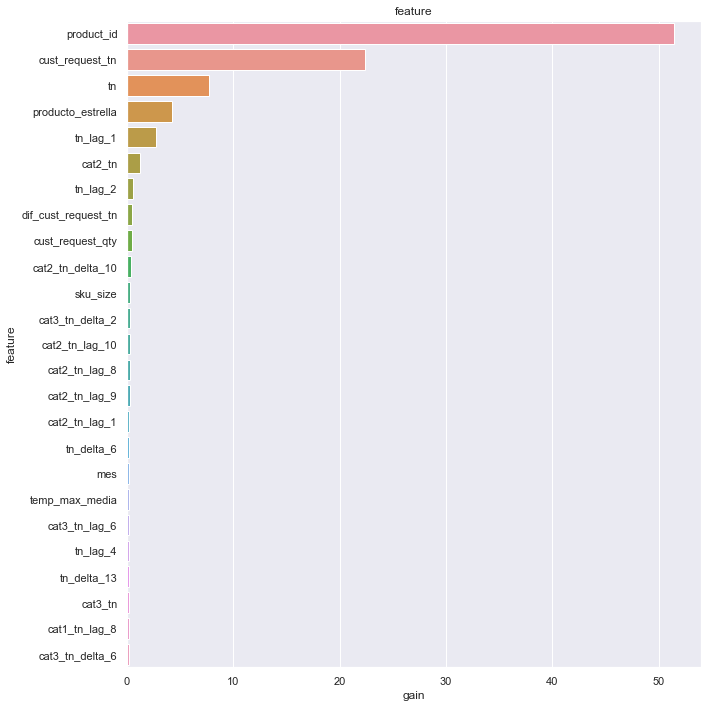

,feature,split,gain
0,product_id,3517,51.43
2,cust_request_tn,1512,22.38
1,tn,1571,7.76
11,producto_estrella,171,4.25
20,tn_lag_1,1768,2.74
...,...,...,...
80,cat1_tn_delta_15,40,0.00
79,cat1_tn_lag_15,31,0.00
7,cat1,4,0.00
4,plan_precios_cuidados,2,0.00


In [28]:
plot_lgb_importances(best_model, num=30, plot=True)

In [29]:
GLOBAL_PRODUCT_IDS = actualizar_global_prods(y_validate_orig)

y_pred_validate = best_model.predict(X_validate)
er_validate = error_rate(y_validate,y_pred_validate)
er_validate

22.52

## Modelo Final

In [30]:
final_model = lgb.train(best_lgb_params, lgbtrain_all, num_boost_round=best_model.best_iteration)

In [31]:
GLOBAL_PRODUCT_IDS = actualizar_global_prods(y_holdout_orig)

y_pred_holdout = final_model.predict(X_holdout)
er_holdout = error_rate(y_holdout,y_pred_holdout)
er_holdout

25.75

In [32]:
print(X_holdout.shape)
df_prediccion = X_holdout.copy()
df_prediccion["tn_target"]=np.array(y_holdout_orig)
df_prediccion["tn_predicted"]=np.array(destransformar_vector(y_pred_holdout))
print(df_prediccion.shape)

(868, 143)
(868, 145)


In [33]:
print("Toneladas Holdout:\t", df_prediccion.tn_target.sum())
print("Toneladas Prediccion:\t", df_prediccion.tn_predicted.sum())

Toneladas Holdout:	 33763.86541
Toneladas Prediccion:	 32371.109409279637


In [34]:
df_prediccion = df_prediccion.sort_values(by="product_id",ascending=True)
df_prediccion.to_csv(arch_predicciones_full, index=False)
df_prediccion[["product_id","tn_predicted"]].to_csv(arch_predicciones_simple, index=False)

In [35]:
print("Error Rate Validate:",er_validate)
print("Error Rate Holdout:",er_holdout)

Error Rate Validate: 22.52
Error Rate Holdout: 25.75


In [36]:
best_lgb_params

{'objective': 'regression',
 'first_metric_only': True,
 'boost_from_average': True,
 'max_bin': 31,
 'max_depth': -1,
 'min_gain_to_split': 0.0,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'force_row_wise': True,
 'feature_pre_filter': False,
 'metric': 'None',
 'learning_rate': 0.01,
 'num_leaves': 99,
 'feature_fraction': 0.7,
 'min_data_in_leaf': 43,
 'bagging_freq': 8,
 'bagging_fraction': 0.8,
 'extra_trees': False,
 'verbose': -100,
 'num_threads': -1}

In [37]:
df_resultado = pd.DataFrame(data={"error_rate_validation":er_validate_iter,"error_rate_holdout": er_holdout_iter, "params":params_iter})

datetime_string = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M')
df_resultado.to_excel("resultados_random_search_"+GLOBAL_TRANSF+"_"+str(iteraciones_random_search)+"_"+datetime_string+".xlsx",index=False)

In [38]:
duration = 500  # 1000 milliseconds = 1 second
winsound.Beep(2000, duration)